Set the paths for directories

In [34]:
import json

def load_annotations(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

annotations_directory_path = 'eccv_18_annotation_files/'
train_annotations = load_annotations(f'{annotations_directory_path}train_annotations.json')
test_annotations = load_annotations(f'{annotations_directory_path}cis_test_annotations.json')
val_annotations = load_annotations(f'{annotations_directory_path}cis_val_annotations.json')


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class CCTDataset(Dataset):
    def __init__(self, annotations, images_directory_path, output_size=(256, 256)):
        self.images_directory_path = images_directory_path
        self.output_size = output_size  # New attribute to store the output size
        self.annotations = annotations

        # Mapping from image ID to image information
        self.image_id_to_info = {image['id']: image for image in annotations['images']}

        # Mapping from category ID to category name
        self.category_id_to_name = {category['id']: category['name'] for category in annotations['categories']}

        # Assuming each image has only one annotation for simplicity. If there are multiple, this needs adjustment.
        self.image_id_to_annotation = {annotation['image_id']: annotation for annotation in annotations['annotations']}

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        image_info = self.annotations['images'][idx]
        img_id = image_info['id']
        img_path = os.path.join(self.images_directory_path, image_info['file_name'])

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Image not found: {img_path}")
            return None

        # Original image size
        orig_size = image.size  # (width, height)

        # Resize image and bounding box
        image = transforms.Resize(self.output_size)(image)
        annotation = self.image_id_to_annotation.get(img_id, {})
        bbox = annotation.get('bbox', [0, 0, 0, 0])
        bbox = self.resize_bbox(bbox, orig_size, self.output_size)

        # Apply additional transformations (e.g. ToTensor)
        image = transforms.ToTensor()(image)

        category_id = annotation.get('category_id', -1)
        category_name = self.category_id_to_name.get(category_id, 'Unknown')

        # Return the image, category name, and resized bounding box
        return image, category_name, bbox

    @staticmethod
    def resize_bbox(bbox, orig_size, new_size):
        """
        Resize bounding box coordinates.
        bbox: Tuple (x_min, y_min, x_max, y_max)
        orig_size: Original size of image (width, height)
        new_size: New size of image (width, height)
        """
        x_min, y_min, x_max, y_max = bbox
        orig_width, orig_height = orig_size
        new_width, new_height = new_size

        # Calculate scale factors
        scale_x = new_width / orig_width
        scale_y = new_height / orig_height

        # Apply scale factors to bbox coordinates
        x_min_new = x_min * scale_x
        y_min_new = y_min * scale_y
        x_max_new = x_max * scale_x
        y_max_new = y_max * scale_y

        return (x_min_new, y_min_new, x_max_new, y_max_new)


In [37]:
# Assuming your images are stored in a single directory
images_directory_path = 'eccv_18_all_images_sm/'

# Initialize the train dataset
train_dataset = CCTDataset(train_annotations, images_directory_path)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#Initialize the val dataset
val_dataset = CCTDataset(val_annotations, images_directory_path)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

#Initialize the test dataset
test_dataset = CCTDataset(test_annotations, images_directory_path)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

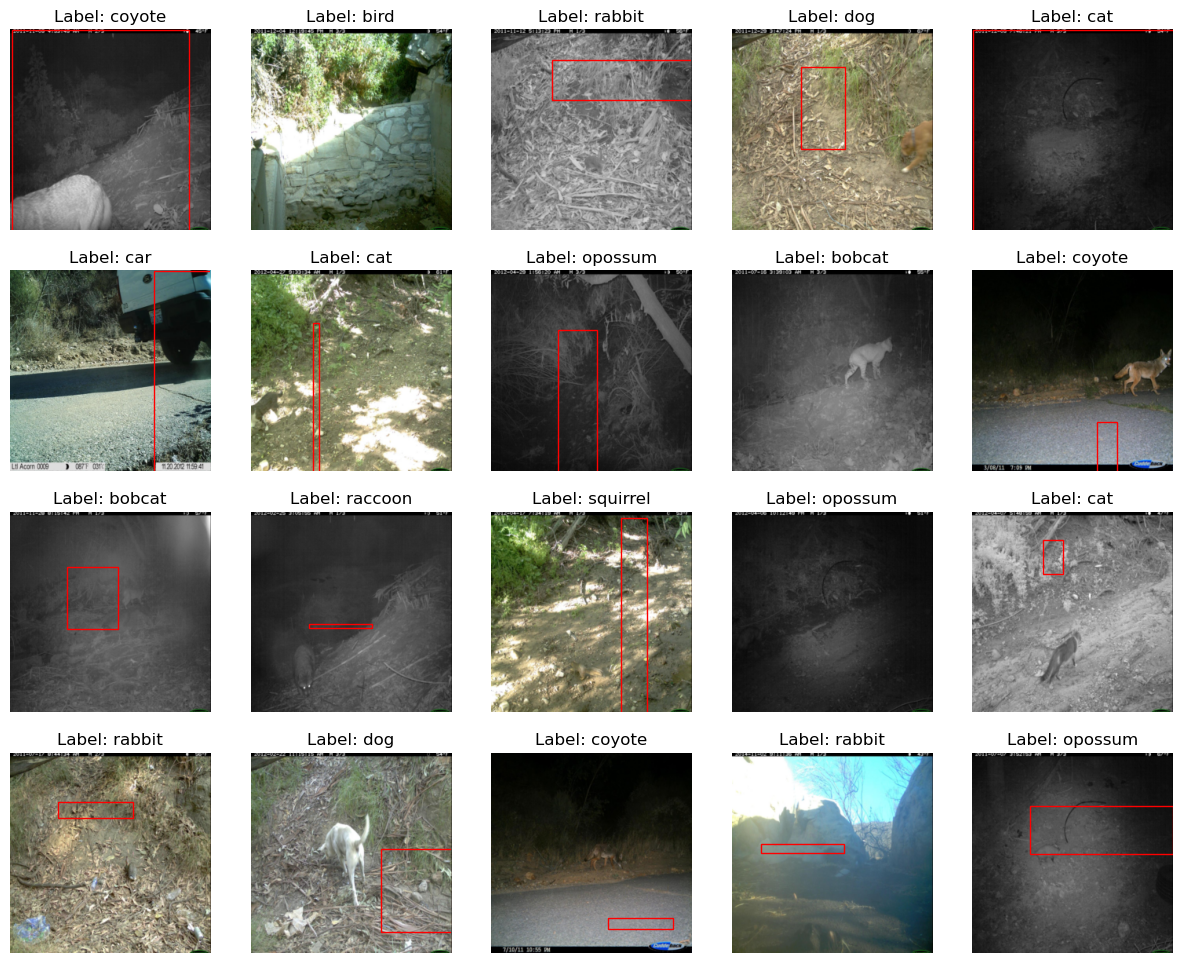

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def print_first_n_images(data_loader, num_images=10, columns=5):
    """
    Prints the first `num_images` images from the DataLoader using subplots
    with bounding boxes.

    Args:
        data_loader (DataLoader): The DataLoader from which to fetch images.
        num_images (int): Number of images to print.
        columns (int): Number of columns in the subplot grid.
    """
    # Calculate number of rows needed
    rows = num_images // columns + (num_images % columns > 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3))
    axs = axs.flatten()  # Flatten the array of axes for easier iteration

    # Setting up a counter to keep track of how many images have been printed
    image_count = 0

    # Iterating over batches in the DataLoader
    for images, labels, bboxes in data_loader:
        for i in range(len(images)):
            if image_count >= num_images:
                # Hide any unused axes if num_images isn't a perfect multiple of columns * rows
                for ax in axs[image_count:]:
                    ax.axis('off')
                plt.show()
                return  # Stop if we have printed the desired number of images

            # Plotting the image in the specified subplot
            img = images[i].numpy().transpose((1, 2, 0))
            axs[image_count].imshow(img)
            axs[image_count].set_title(f"Label: {labels[i]}")
            
            # Get the bounding box
            bbox = bboxes[i]
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), # Lower left point
                bbox[2] - bbox[0],  # Width
                bbox[3] - bbox[1],  # Height
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )

            # Add the patch to the Axes
            axs[image_count].add_patch(rect)
            axs[image_count].axis('off')

            # Increment the counter
            image_count += 1

    # Ensure the remaining unused subplots are not visible
    for ax in axs[image_count:]:
        ax.axis('off')

    # Display all the subplots
    plt.show()

# Example usage: print the first 20 images in a grid with bounding boxes
print_first_n_images(train_loader, num_images=20, columns=5)
